## Importing libraries and reading in data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

%matplotlib inline

In [2]:
reddit_posts_df = pd.read_csv('combinedData.csv')
reddit_posts_df

,selftext,subreddit,title
0,"""It's A Little Fit Bunny.""",1,Elton John has bought his pet rabbit a treadmill.
1,A Perfect Urkel,1,OK hear me out. Jaleel White. Maynard James Ke...
2,"""How do you determine whether or not an older ...",1,THE BATHTUB TEST: During a visit to my doctors...
3,A Luigi board!,1,How does the Italian plumber talk to spirits?
4,A quack-job.,1,What do you call a blowjob from someone preten...
...,...,...,...
3468,"Without missing a beat, she replies with ""Buga...",0,Proud of my wife for this one. I'm playing a n...
3469,\r\n\r\n\r\n\r\n\r\n\r\n\r\nYee-Hanukkah\r\n\r...,0,From my 10 year old daughter… What does a Jewi...
3470,‘I knead it for work.’,0,Baker to wife: ‘can you pick up some flour?’
3471,Wet.,0,What do you get when you cross a like and a ri...


## Wordcloud for some EDA

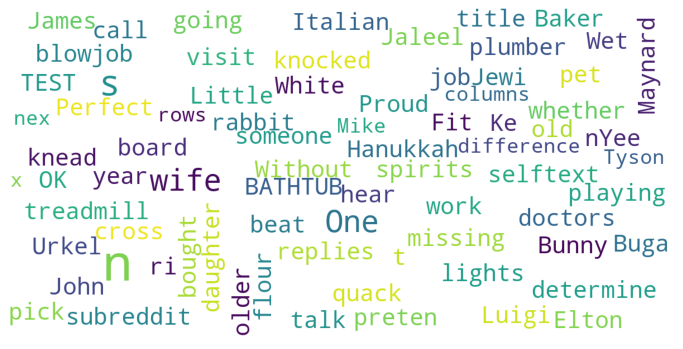

In [3]:
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()
    
    
stopwords = set(STOPWORDS) 
show_wordcloud(reddit_posts_df)

### Creating a features list with text and title (X) and the subreddit as the target (Y)

In [4]:
features = ['selftext', 'title']
X = reddit_posts_df[features]
y = reddit_posts_df.subreddit

In [5]:
X.head()

,selftext,title
0,"""It's A Little Fit Bunny.""",Elton John has bought his pet rabbit a treadmill.
1,A Perfect Urkel,OK hear me out. Jaleel White. Maynard James Ke...
2,"""How do you determine whether or not an older ...",THE BATHTUB TEST: During a visit to my doctors...
3,A Luigi board!,How does the Italian plumber talk to spirits?
4,A quack-job.,What do you call a blowjob from someone preten...


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=101,test_size=0.3,stratify=y)

## Cleaning data
### Using a count vectorizer to remove english stop words, strip ascii accents and clean any noise from text/title data

In [7]:
cv_text = CountVectorizer(stop_words='english', strip_accents = 'ascii', ngram_range=(1, 7), min_df=.03) #0.30,0.95
cv_title = CountVectorizer(stop_words='english', strip_accents = 'ascii', ngram_range=(1, 4), min_df=.01)

### Splitting data further into seperate text and title dataframes

In [8]:
X_train_text = cv_text.fit_transform(X_train.selftext.values.astype('U'))
X_train_title = cv_title.fit_transform(X_train.title)

X_test_text = cv_text.transform(X_test.selftext.values.astype('U'))
X_test_title = cv_title.transform(X_test.title)
#x = v.fit_transform(df['Review'].values.astype('U'))
#print(X_test_text)

In [9]:
X_train_text_df = pd.DataFrame(X_train_text.todense(), columns=[x+'_selftext' for x in cv_text.get_feature_names()])
X_train_title_df = pd.DataFrame(X_train_title.todense(), columns=[y+'_title' for y in cv_title.get_feature_names()])
X_test_text_df = pd.DataFrame(X_test_text.todense(), columns=[x+'_selftext' for x in cv_text.get_feature_names()])
X_test_title_df = pd.DataFrame(X_test_title.todense(), columns=[y+'_title' for y in cv_title.get_feature_names()])

C:\Users\Imoesi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Concatenating both training and testing data again

In [10]:
trained_reddit_posts = pd.concat([X_train_text_df, X_train_title_df], axis=1)
tested_reddit_posts = pd.concat([X_test_text_df, X_test_title_df], axis=1)
trained_reddit_posts.shape

(2431, 57)

In [11]:
# making sure no null values in data
trained_reddit_posts.isnull().sum().sum()

0

## Logistic regression model

In [12]:
def lr_model(model):
    
    if model == 'lr_1':
        lr_1_params = {
            'penalty': ['l1'], 'C': [0.001,0.01,0.1,1,10,100,1000], 
            'class_weight': ['balanced'], 'warm_start': [True, False],
            'random_state': [101], 'solver': ['liblinear']}
        
        M = GridSearchCV(LogisticRegression(), lr_1_params, cv = 5, verbose = 1, n_jobs = -1)
        
    elif model == 'lr_2':
        lr_2_params = {'penalty': ['l2'], 'C': [0.001,0.01,0.1,1,10,100,1000], 
            'class_weight': ['balanced'], 'warm_start': [True, False],            
            'random_state': [101], 'solver': ['lbfgs', 'liblinear']}
        
        M = GridSearchCV(LogisticRegression(), lr_2_params, cv = 5, verbose = 1, n_jobs = -1)

    else:
        print('Error, wrong lr penalty')
        
    M.fit(trained_reddit_posts.values, y_train) 
    print(f'Training score = {M.score(trained_reddit_posts.values, y_train)}')
    print(f'Testing score = {M.score(tested_reddit_posts.values, y_test)}')
    
    predictions = M.predict(tested_reddit_posts.values)
    #predictions = M.predict(X_test)
    print('--------')
    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test,predictions))
    print(f'best parameters = {M.best_params_}')


In [13]:
lr_model('lr_1')

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Training score = 0.6240230357877417
Testing score = 0.6228406909788867
--------
[[423 101]
 [292 226]]
              precision    recall  f1-score   support

           0       0.59      0.81      0.68       524
           1       0.69      0.44      0.53       518

    accuracy                           0.62      1042
   macro avg       0.64      0.62      0.61      1042
weighted avg       0.64      0.62      0.61      1042

best parameters = {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 101, 'solver': 'liblinear', 'warm_start': True}


In [14]:
lr_model('lr_2')

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Training score = 0.6236116824352118
Testing score = 0.6228406909788867
--------
[[423 101]
 [292 226]]
              precision    recall  f1-score   support

           0       0.59      0.81      0.68       524
           1       0.69      0.44      0.53       518

    accuracy                           0.62      1042
   macro avg       0.64      0.62      0.61      1042
weighted avg       0.64      0.62      0.61      1042

best parameters = {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 101, 'solver': 'lbfgs', 'warm_start': True}


## Naive Bayes Model

In [15]:
def naiveBayes(model):
    if model == 'modelOne':
        
        mn_params = {
            'fit_prior': [True],
            'alpha': [0, 0.5, 1]}
        
        M = GridSearchCV(MultinomialNB(), mn_params, cv = 5, verbose = 1, n_jobs = -1)
        
    elif model == 'modelTwo':
        
        mn_params = {
            'fit_prior': [False],
            'alpha': [0, 0.5, 1]}
        
        M = GridSearchCV(MultinomialNB(), mn_params, cv = 5, verbose = 1, n_jobs = -1)
        
    else:
        print('There is an error.')
        
    M.fit(trained_reddit_posts.values, y_train)
     
    print(f'Training score = {M.score(trained_reddit_posts.values, y_train)}')
    print(f'Testing score = {M.score(tested_reddit_posts.values, y_test)}')
    
    predictions = M.predict(tested_reddit_posts.values)
    print('--------')
    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test,predictions))
    print(f'Best params = {M.best_params_}')

In [16]:
naiveBayes('modelOne')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Training score = 0.6075689016865488
Testing score = 0.6209213051823417
--------
[[463  61]
 [334 184]]
              precision    recall  f1-score   support

           0       0.58      0.88      0.70       524
           1       0.75      0.36      0.48       518

    accuracy                           0.62      1042
   macro avg       0.67      0.62      0.59      1042
weighted avg       0.67      0.62      0.59      1042

Best params = {'alpha': 1, 'fit_prior': True}


In [17]:
naiveBayes('modelTwo')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Training score = 0.6071575483340189
Testing score = 0.6209213051823417
--------
[[463  61]
 [334 184]]
              precision    recall  f1-score   support

           0       0.58      0.88      0.70       524
           1       0.75      0.36      0.48       518

    accuracy                           0.62      1042
   macro avg       0.67      0.62      0.59      1042
weighted avg       0.67      0.62      0.59      1042

Best params = {'alpha': 0.5, 'fit_prior': False}
